# EECE 5639 - Project 1

Matin Raayai Ardakani

Tony Smoragiewicz

Northeastern University

Fall 2021

In [13]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import tqdm
from scipy.ndimage import convolve, median_filter

### Dataset pre-processing

In [14]:
"""
Loads in images in a single folder and converts them to gray scale.
The images are returned as a python list
"""
def load_images_from_folder(folder):
    images = []
    for filename in tqdm.tqdm(sorted(os.listdir(folder))):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            gray = np.sum(img, 2) / 3
            images.append(gray)
    return images
"""
Saves the temporal masks to the specified folder.
"""
def save_masks_to_folder(masks, folder):
    for m in tqdm.tqdm(masks):
        output_path = os.path.join(folder, f"{i:4d}.png")
        cv2.imwrite(output_path, m.astype(np.uint8), cv2.IMWRITE_PAM_FORMAT_GRAYSCALE)

In [15]:
office_dataset_path = "../Datasets/Office/"
red_chair_dataset_path = "../Datasets/RedChair"
office = np.array(load_images_from_folder(office_dataset_path))
red_chair = np.array(load_images_from_folder(red_chair_dataset_path))

print(f"Office dataset shape: {office.shape}")
print(f"Red chair dataset shape: {red_chair.shape}")

100%|██████████| 353/353 [00:00<00:00, 586.73it/s]


Office dataset shape: (1070, 240, 320)
Red chair dataset shape: (353, 240, 320)


### Filtering and Plotting Functions

In [66]:
def abs_and_thres(masks, min_thres=0, max_thres=500):
    masks = np.abs(masks)
    return np.select([masks > min_thres, masks < max_thres],
                 [np.ones_like(masks), np.zeros_like(masks)])

def convolve_temporal_filter(images, temp_filter):
    temp_filter = temp_filter.reshape(-1, 1, 1)
    return convolve(images.astype(np.float64), temp_filter)

def get_temporal_gaussian_1d(t_sigma):
    output = [ - np.exp(- x**2 / (2 * t_sigma**2)) * x / (t_sigma**2) for x
    in range(-5 * t_sigma, 5 * t_sigma + 1)]
    output = np.array(output)
    return output / output.sum()

def get_spatial_gaussian_2d(s_sigma):
    filt_rad = int(np.floor(5 * s_sigma))
    offset = np.floor(filt_rad/2)
    print(offset)
    g_filt_2d = np.zeros((filt_rad, filt_rad), dtype=np.float64)
    for i in range(filt_rad):
        for j in range(filt_rad):
            g_filt_2d[i, j] = np.exp(-((i - offset)**2 + (j - offset)**2) / (2 * s_sigma**2))
    g_filt_2d = g_filt_2d / g_filt_2d.sum()
    return g_filt_2d


def apply_median_filter(images, kernel):
    return median_filter(images, kernel)


def convolve_spatial_filter(images, spatial_filter):
    spatial_filter = spatial_filter.reshape(1,
                                            spatial_filter.shape[0],
                                            spatial_filter.shape[1])
    return convolve(images, spatial_filter)

### Spatial and Temporal Filters

In [17]:
naive_temp_filter = 0.5 * np.array([-1.,0.,1.])

## Experiments

### b.i. Naive Temporal Filtering

In [18]:
office_exp_1 = convolve_temporal_filter(office, naive_temp_filter)
office_exp_1 = abs_and_thres(office_exp_1, 10, 200)
red_chair_exp_1 = convolve_temporal_filter(red_chair, naive_temp_filter)
red_chair_exp_1 = abs_and_thres(red_chair_exp_1, 10, 200)

### b.ii. Temporal denoising with spatial pre-processing

In [69]:
# create kernels
box3 = np.ones([3,3])
box5 = np.ones([5,5])
gauss1 = get_spatial_gaussian_2d(1)
gauss14 = get_spatial_gaussian_2d(1.4)

2.0
3.0


In [72]:
# smooth office images
office_exp_2_b3 = convolve_spatial_filter(office,box3)
office_exp_2_b5 = convolve_spatial_filter(office,box5)
office_exp_2_gauss1 = convolve_spatial_filter(office,gauss1)
office_exp_2_gauss14 = convolve_spatial_filter(office,gauss14)

# smooth red_chair images
red_chair_exp_2_b3 = convolve_spatial_filter(red_chair,box3)
red_chair_exp_2_b5 = convolve_spatial_filter(red_chair,box5)
red_chair_exp_2_gauss1 = convolve_spatial_filter(red_chair,gauss1)
red_chair_exp_2_gauss14 = convolve_spatial_filter(red_chair,gauss14)

In [45]:
# apply temporal filter
office_exp_2_b3 = convolve_temporal_filter(office_exp_2_b3, naive_temp_filter)
office_exp_2_b5 = convolve_temporal_filter(office_exp_2_b5, naive_temp_filter)
office_exp_2_gauss1 = convolve_temporal_filter(office_exp_2_gauss1, naive_temp_filter)
office_exp_2_gauss2 = convolve_temporal_filter(office_exp_2_gauss14, naive_temp_filter)

red_chair_exp_2_b3 = convolve_temporal_filter(office_exp_2_b3, naive_temp_filter)
red_chair_exp_2_b5 = convolve_temporal_filter(office_exp_2_b5, naive_temp_filter)
red_chair_exp_2_gauss1 = convolve_temporal_filter(office_exp_2_gauss1, naive_temp_filter)
red_chair_exp_2_gauss14 = convolve_temporal_filter(office_exp_2_gauss14, naive_temp_filter)

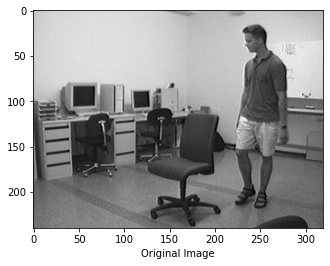

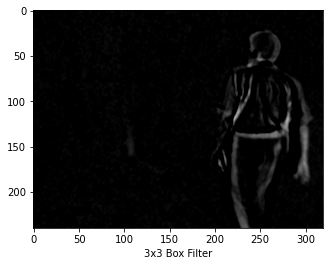

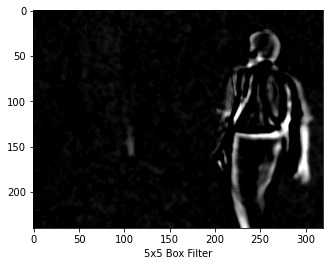

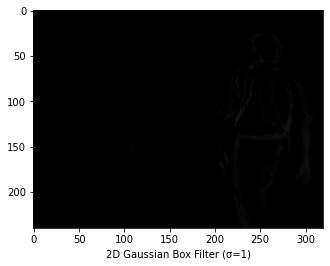

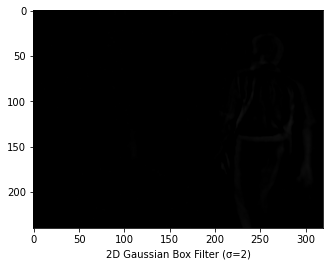

In [46]:
im = 62
plt.imshow(red_chair[im,:,:], cmap='gray', vmin=0, vmax=255)
plt.xlabel('Original Image')
plt.show()

plt.imshow(red_chair_exp_2_b3[im,:,:], cmap='gray', vmin=0, vmax=255)
plt.xlabel('3x3 Box Filter')
plt.show()

plt.imshow(red_chair_exp_2_b5[im,:,:], cmap='gray', vmin=0, vmax=255)
plt.xlabel('5x5 Box Filter')
plt.show()

plt.imshow(red_chair_exp_2_gauss1[im,:,:], cmap='gray', vmin=0, vmax=255)
plt.xlabel('2D Gaussian Box Filter (\u03C3=1)')
plt.show()

plt.imshow(red_chair_exp_2_gauss14[im,:,:], cmap='gray', vmin=0, vmax=255)
plt.xlabel('2D Gaussian Box Filter (\u03C3=2)')
plt.show()

NameError: name 'temp_median' is not defined

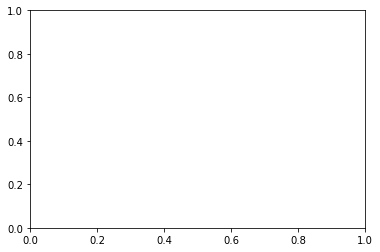

In [19]:
plt.subplot()
im = np.random.randint(idx)
plt.imshow(temp_median[im,:,:], cmap='gray', vmin=0, vmax=255)
print(im)

In [ ]:
# Temporal gradient
motion = np.zeros((idx-1, r, c))
for i in range(idx-1):
    temp_grad = denoise[i,:,:] - temp_median[i-1,:,:]
    #temp_grad = 0.5*(denoise[i+1,:,:] - denoise[i-1,:,:])
    motion[i,:,:] = np.abs(temp_grad)
    motion[i,:,:] = temp_grad**2/255
noise_line  = np.reshape(motion, ((idx-1)*r*c, 1) )

plt.subplot()
plt.hist(noise_line, bins=255)
plt.ylim([0,100000])
plt.xlim([1,255])

In [ ]:
# Apply a threshold
mask = np.zeros((idx-1, r, c))
threshold = 5
for i in range(idx-1):
    mask[i] = (motion[i,:,:] > threshold)*images[i,:,:]
mask_line  = np.reshape(mask, ((idx-1)*r*c, 1) )

plt.subplot()
plt.hist(mask_line, bins=255)
plt.ylim([0,100000])
plt.xlim([1,255])

In [ ]:
# Tough Images
plt.subplot()
im = 188
plt.imshow(motion[im,:,:], cmap='gray', vmin=0, vmax=255)
print(im)
print(np.amax(motion[im,:,:]))

In [ ]:
plt.subplot()
im = np.random.randint(idx)
im = 62
plt.imshow(mask[im,:,:], cmap='gray', vmin=0, vmax=255)
print(im)
print(np.amax(mask[im,:,:]))

In [ ]:
im = np.random.randint(idx)
im = 62
print(im)
plt.subplot()
plt.imshow(images[im,:,:], cmap='gray', vmin=0, vmax=255)
plt.imshow(mask[im,:,:], cmap='jet', alpha=0.5, vmin=0, vmax=255)